# Temporal statistical moments of Ifremer p1 SWH and WSP daily data from Jaunary 1st, 1993 to December 31st, 2015 

Plot figure within jupyter notebook

In [1]:
%matplotlib inline

Use the sys library in order to tell the notebook to look for files within the followinf directory path: 

In [2]:
import sys
sys.path.append('/zdata/home/lcolosi/python_functions/')

Import all libraries and functions

In [3]:
#libraries
import numpy as np #contains the major of functions used for matrix arrays  
import matplotlib.pyplot as plt # matplotlib contains functions for graphics and plot manipulation
from netCDF4 import Dataset, num2date # netCDF4 handles netCDF files
import datetime
#plotting libraries
import cmocean.cm as cmo
from matplotlib import cm 
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import ticker
import matplotlib
from numpy import pi


#my functions
from statistical_moments_temporal import stat_moments_temporal
import cartopy_fig_module as cart

Set dimensions for data of space and time which depends on the spatial orientation of the data set and the time period which the data is collected from. For the Ifremer data set, we want the following data orientation: 

In [4]:
nt, nlon, nlat = 8400, 360, 133
initial_year = 1993
final_year = 2015
initial_mon = 1
final_mon = 12

Set filename and look at key variables and attributes

In [5]:
#Bia's binned data: 
#filename = '/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/bia_daily_binned_ifremer_data/all_sat_binned_swh_1992-08-23_2016-08-23.nc'
#My binned data: 
filename_swh = '/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/my_daily_binned_ifremer_data/ifremer_swh_daily_binned_data_93_16_bia.nc'
filename_wsp = '/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/my_daily_binned_ifremer_data/ifremer_wsp_daily_binned_data_93_16_bia.nc'

#set nc variable in order to read attributes and obtained data: 
#bia's data:
#nc = Dataset(filename, 'r')
#My data
nc_swh =  Dataset(filename_swh, 'r')
nc_wsp =  Dataset(filename_wsp, 'r')

#print key variables:
print(nc_swh.variables.keys())

#longitude
for at in nc_swh.variables['lon'].ncattrs():
    print("%s : %s" %(at, nc_swh.variables['lon'].getncattr(at)))

#laitude
for at in nc_swh.variables['lat'].ncattrs():
    print("%s : %s" %(at, nc_swh.variables['lat'].getncattr(at)))
    
#time 
for at in nc_swh.variables['time'].ncattrs():
    print("%s : %s" %(at, nc_swh.variables['time'].getncattr(at)))

odict_keys(['time', 'lon', 'lat', 'swh'])
units : degrees east
units : degrees north
units : days since 1900-01-01 00:00:00
calendar : julian


Call Ifremer Product 1 daily binned data from the server

In [6]:
swh = nc_swh.variables['swh'][:]
wsp = nc_wsp.variables['wsp'][:]
lon = nc_swh.variables['lon'][:]
lat = nc_swh.variables['lat'][:]
time_i = num2date(nc_swh.variables['time'][:], nc_swh.variables['time'].units) #convert time directly into datetime format instead of integer value time 

Restrict the latitude dimension of the swh and wsp data from -66 to 66 because SWH and WSP range from -90 to 90 

In [7]:
swh = swh[:,24:157,:]
wsp = wsp[:,24:157,:]
lat = lat[24:157]
print(lat.shape, swh.shape)

(133,) (8766, 133, 360)


Check to see if swh and wsp are masked arrays

In [8]:
print(swh.shape,time_i.shape)

(8766, 133, 360) (8766,)


Restrict the time series from 1993 to 2015 for swh_cor 

In [9]:
#find initial and final indices: 
#create year vector: 
years = np.array([y.year for y in time_i])

#creat boolean arrays and combine them: 
#ind_92 = years != 1992
ind_16 = years != 2016
#ind_time = ind_92*ind_16
ind_time = ind_16

#use the compress function to find all indices that do not lie in 1992 or 2016 and extract slices of matirx along the time axis from swh
swh_c = np.compress(ind_time, swh, axis = 0)
wsp_c = np.compress(ind_time, wsp, axis = 0)
print(swh_c.shape,wsp_c.shape)

#extract the time steps: 
time_c = time_i[ind_time]
print(len(time_c))


(8400, 133, 360) (8400, 133, 360)
8400


Compute statistical moments of the data seasonally

In [10]:
swh_stats_s = stat_moments_temporal(data=swh_c, date_time=time_c, task='seasonally')
wsp_stats_s = stat_moments_temporal(data=wsp_c, date_time=time_c, task='seasonally')

Assign key variables from dictionary as variables and convert variables to numpy arrays

In [11]:
#For SWH:
swh_mean_s = np.ma.array(swh_stats_s['mean'])
swh_var_s = np.ma.array(swh_stats_s['var'])
swh_skew_s = np.ma.array(swh_stats_s['skew'])
swh_kurt_s = np.ma.array(swh_stats_s['kurt'])

#For WSP:
wsp_mean_s = np.ma.array(wsp_stats_s['mean'])
wsp_var_s = np.ma.array(wsp_stats_s['var'])
wsp_skew_s = np.ma.array(wsp_stats_s['skew'])
wsp_kurt_s = np.ma.array(wsp_stats_s['kurt'])

Plot the seasonal progression for each statistical moment using cartopy 

#### SWH

###### Mean

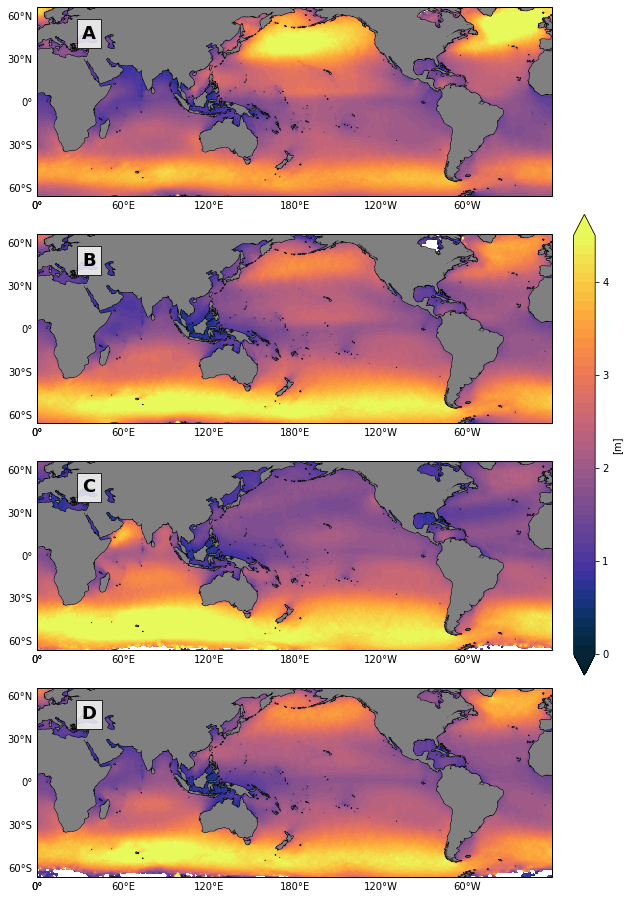

In [12]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 4.6, 0.1)
cs1 = ax1.contourf(lon, lat, swh_mean_s[0,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 4.6, 0.1)
cs2 = ax2.contourf(lon, lat, swh_mean_s[1,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 4.6, 0.1)
cs3 = ax3.contourf(lon, lat, swh_mean_s[2,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 4.6, 0.1)
cs4 = ax4.contourf(lon, lat, swh_mean_s[3,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/Ifremer_prod1/Ifremer_p1_seasonal_mean', bbox_inches = 'tight', dpi=300)

###### Variance

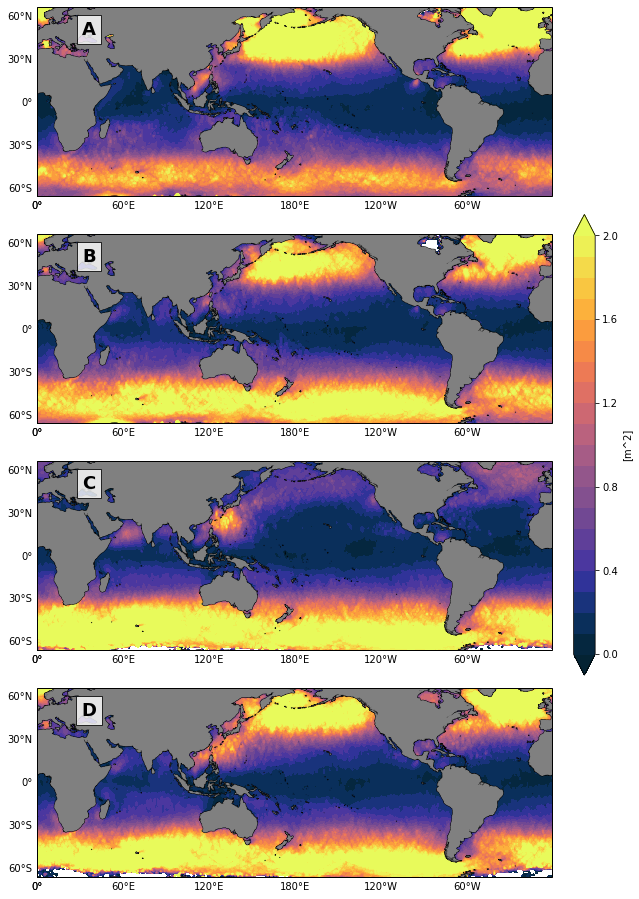

In [13]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs1 = ax1.contourf(lon, lat, swh_var_s[0,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 2.1, 0.1)
cs2 = ax2.contourf(lon, lat, swh_var_s[1,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs3 = ax3.contourf(lon, lat, swh_var_s[2,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 2.1, 0.1)
cs4 = ax4.contourf(lon, lat, swh_var_s[3,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/Ifremer_prod1/Ifremer_p1_seasonal_var', bbox_inches = 'tight', dpi=300)


###### Skewness

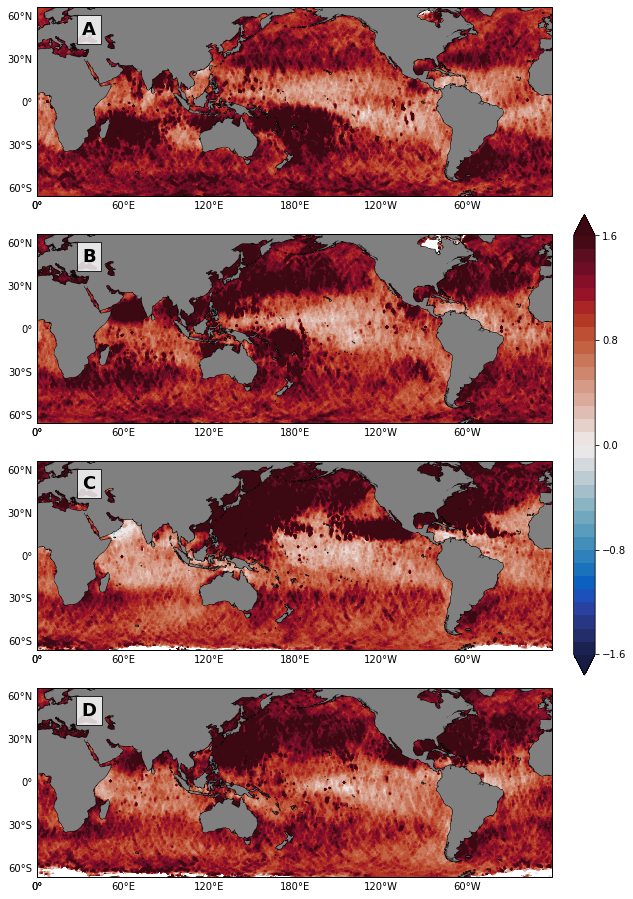

In [14]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.6, 1.7, 0.1)
cs1 = ax1.contourf(lon, lat, swh_skew_s[0,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.6, 1.7, 0.1)
cs2 = ax2.contourf(lon, lat, swh_skew_s[1,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.6, 1.7, 0.1)
cs3 = ax3.contourf(lon, lat, swh_skew_s[2,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.6, 1.7, 0.1)
cs4 = ax4.contourf(lon, lat, swh_skew_s[3,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/Ifremer_prod1/Ifremer_p1_seasonal_skew', bbox_inches = 'tight', dpi=300)


###### Kurtosis

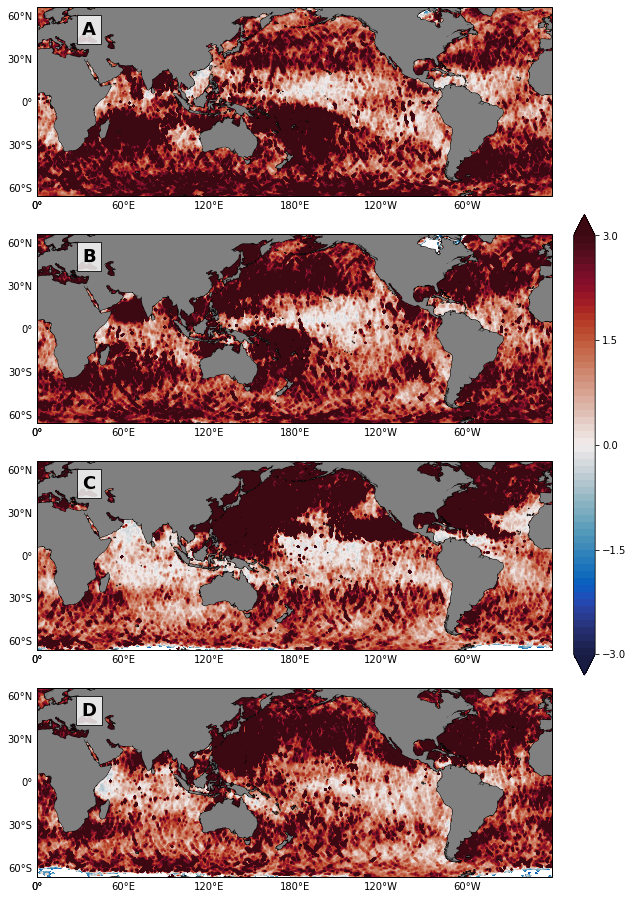

In [15]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-3, 3.1, 0.1)
cs1 = ax1.contourf(lon, lat, swh_kurt_s[0,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-3, 3.1, 0.1)
cs2 = ax2.contourf(lon, lat, swh_kurt_s[1,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-3, 3.1, 0.1)
cs3 = ax3.contourf(lon, lat, swh_kurt_s[2,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-3, 3.1, 0.1)
cs4 = ax4.contourf(lon, lat, swh_kurt_s[3,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/Ifremer_prod1/Ifremer_p1_seasonal_kurt', bbox_inches = 'tight', dpi=300)

#### WSP

###### Mean

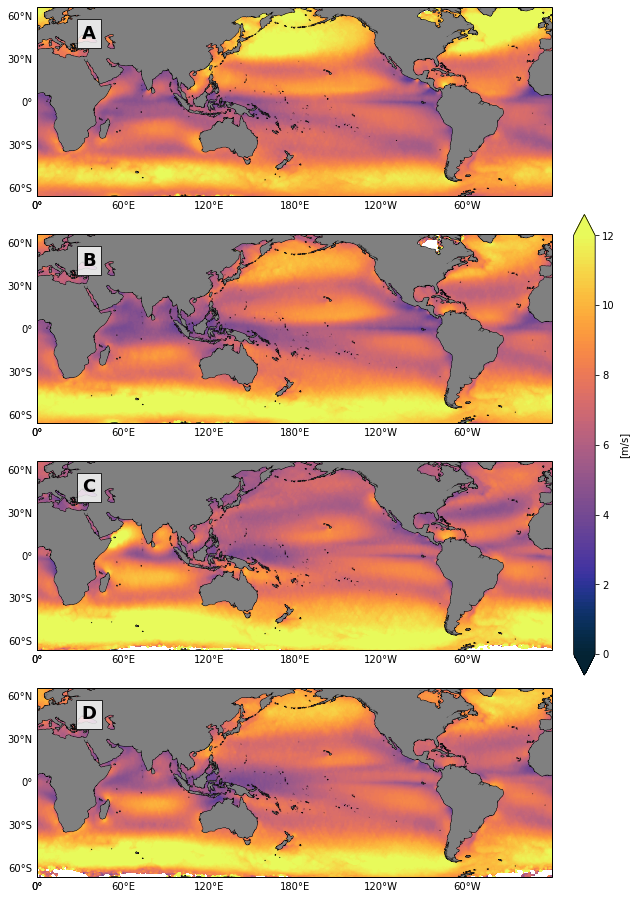

In [16]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 12.1, 0.1)
cs1 = ax1.contourf(lon, lat, wsp_mean_s[0,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='[m/s]', nbins = 6, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 12.1, 0.1)
cs2 = ax2.contourf(lon, lat, wsp_mean_s[1,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 12.1, 0.1)
cs3 = ax3.contourf(lon, lat, wsp_mean_s[2,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 12.1, 0.1)
cs4 = ax4.contourf(lon, lat, wsp_mean_s[3,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/Ifremer_prod1/Ifremer_p1_seasonal_mean_wsp', bbox_inches = 'tight', dpi=300)

###### Variance

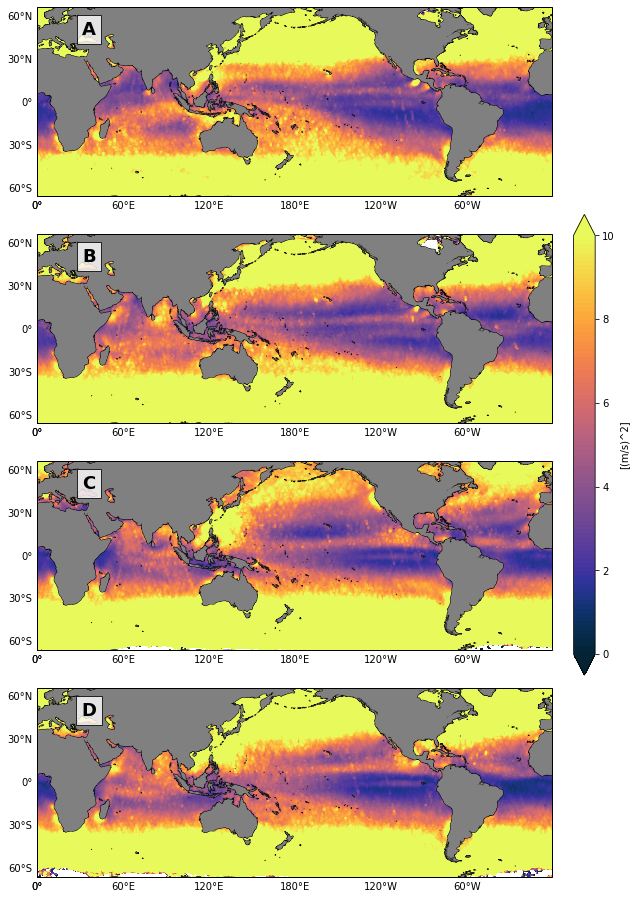

In [17]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 10.1, 0.1)
cs1 = ax1.contourf(lon, lat, wsp_var_s[0,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='[(m/s)^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 10.1, 0.1)
cs2 = ax2.contourf(lon, lat, wsp_var_s[1,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 10.1, 0.1)
cs3 = ax3.contourf(lon, lat, wsp_var_s[2,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 10.1, 0.1)
cs4 = ax4.contourf(lon, lat, wsp_var_s[3,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/Ifremer_prod1/Ifremer_p1_seasonal_var_wsp', bbox_inches = 'tight', dpi=300)


###### Skewness

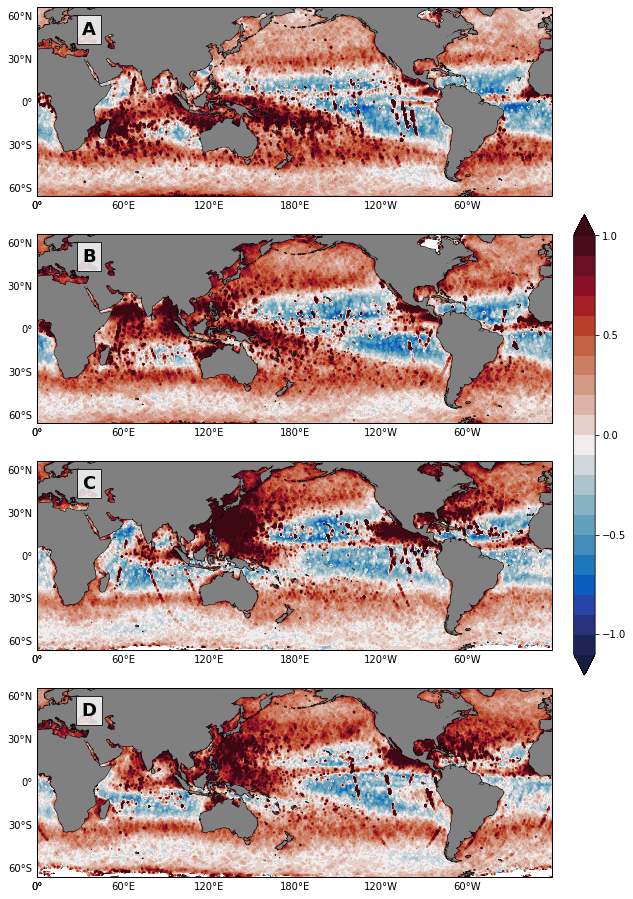

In [18]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.1, 1.1, 0.1)
cs1 = ax1.contourf(lon, lat, wsp_skew_s[0,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.1, 1.1, 0.1)
cs2 = ax2.contourf(lon, lat, wsp_skew_s[1,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.1, 1.1, 0.1)
cs3 = ax3.contourf(lon, lat, wsp_skew_s[2,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.1, 1.1, 0.1)
cs4 = ax4.contourf(lon, lat, wsp_skew_s[3,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/Ifremer_prod1/Ifremer_p1_seasonal_skew_wsp', bbox_inches = 'tight', dpi=300)


###### Kurtosis

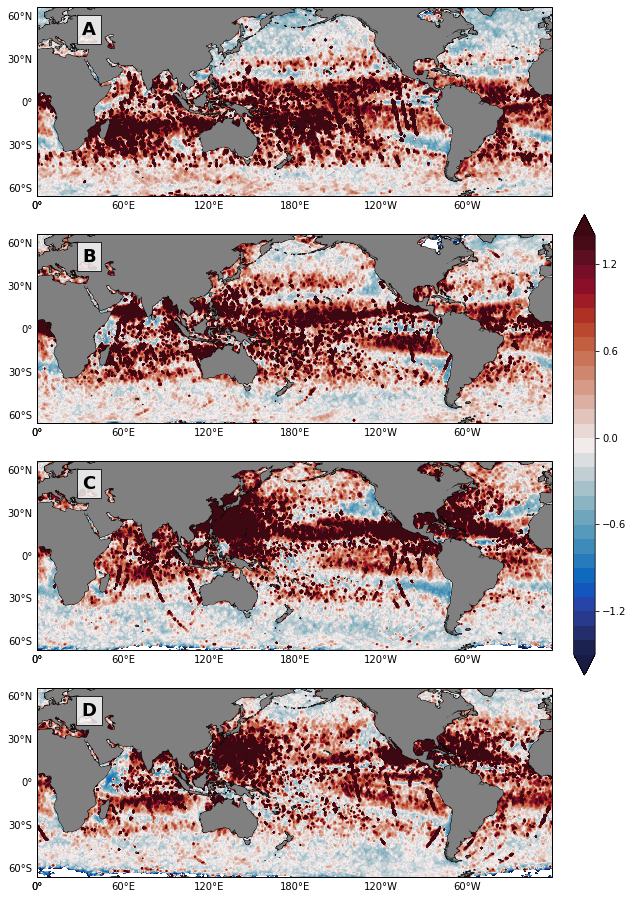

In [19]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.5, 1.5, 0.1)
cs1 = ax1.contourf(lon, lat, wsp_kurt_s[0,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.5, 1.5, 0.1)
cs2 = ax2.contourf(lon, lat, wsp_kurt_s[1,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.5, 1.5, 0.1)
cs3 = ax3.contourf(lon, lat, wsp_kurt_s[2,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.5, 1.5, 0.1)
cs4 = ax4.contourf(lon, lat, wsp_kurt_s[3,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)

#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/Ifremer_prod1/Ifremer_p1_seasonal_kurt_wsp', bbox_inches = 'tight', dpi=300)

Compute statistical moments of the data monthly in order to make sure I am obtaining a realistic mean and variance data globally in order to confirm that the monthly mean and variance in the regional climatologies is correct

In [20]:
swh_stats_m = stat_moments_temporal(data=swh_c, date_time=time_c, task='monthly')
wsp_stats_m = stat_moments_temporal(data=wsp_c, date_time=time_c, task='monthly')

Assign key variables from dictionary as variables and convert variables to numpy arrays

In [21]:
#For SWH:
swh_mean_m = np.ma.array(swh_stats_m['mean'])
swh_var_m = np.ma.array(swh_stats_m['var'])
#swh_skew_s = np.ma.array(swh_stats_s['skew'])
#swh_kurt_s = np.ma.array(swh_stats_s['kurt'])

#For WSP:
wsp_mean_m = np.ma.array(wsp_stats_m['mean'])
wsp_var_m = np.ma.array(wsp_stats_m['var'])
#wsp_skew_s = np.ma.array(wsp_stats_s['skew'])
#wsp_kurt_s = np.ma.array(wsp_stats_s['kurt'])

Plot the month progression for each statistical moment without using cartopy

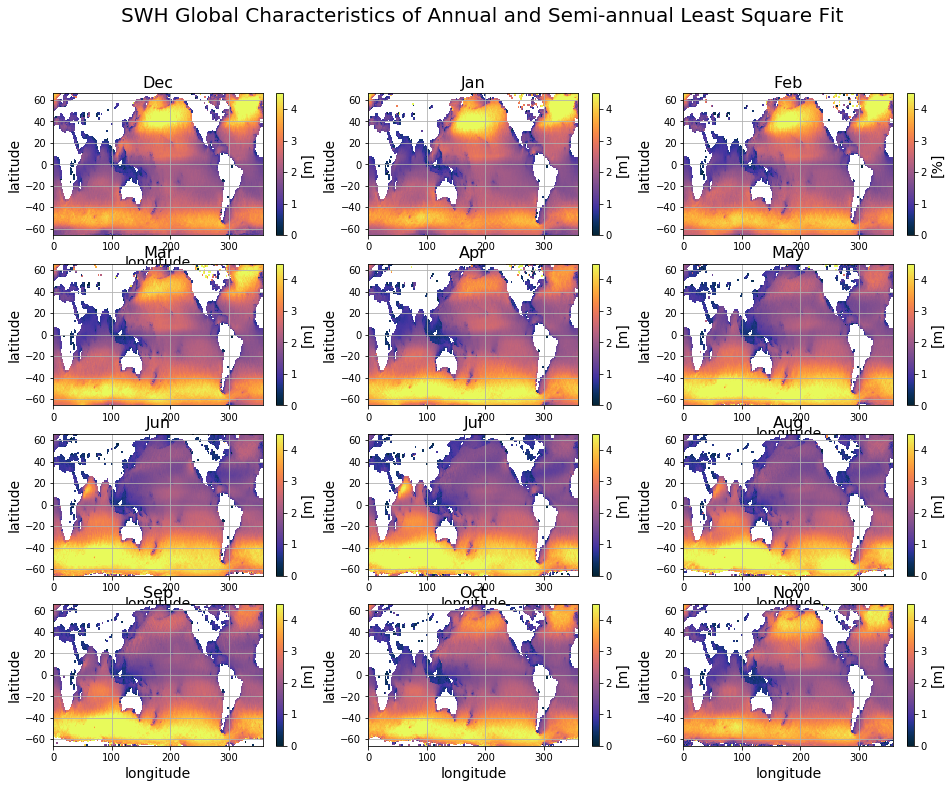

In [22]:
#initialize figure: 
fig1 = plt.figure(figsize=(16, 12))
fig1.suptitle('SWH Global Characteristics of Annual and Semi-annual Least Square Fit ', fontsize=20)

#June Subplot
plt.subplot(4,3,1)
plt.pcolor(lon,lat,swh_mean_m[11,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Dec', fontsize=16)
plt.grid()

#RMS subplot: 
plt.subplot(432)

#pcolor plot: 
plt.pcolor(lon,lat,swh_mean_m[0,:,:],vmin=0,vmax=4.5, cmap=cmo.thermal)

#contourf plot:
#set levels of contours
#levels = np.arange(0.0, 1.1, 0.1)
#plt.contourf(lon,lat,swh_rms_m,levels=levels,cmap=cmo.thermal,extend='min')
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Jan', fontsize=16)
plt.grid()

#Coefficient of Determination subplot: 
plt.subplot(433)
plt.pcolor(lon,lat,swh_mean_m[1,:,:],vmin=0,vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(0.0, 1.1, 0.1)
#plt.contourf(lon,lat,swh_mean_m[1,:,:],levels=levels,cmap=cmo.thermal,extend='min')
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[%]', fontsize=14)
#label figure 
plt.title('Feb', fontsize=16)
plt.grid()

#Annual Amplitude subplot: 
plt.subplot(434)
plt.pcolor(lon,lat,swh_mean_m[2,:,:],vmin=0,vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(0.0, 1.1, 0.1)
#plt.contourf(lon,lat,swh_amp1_m,levels=levels,cmap=cmo.thermal,extend='min')
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Mar', fontsize=16)
plt.grid()

#Semi-annual Amplitude subplot: 
plt.subplot(435)
plt.pcolor(lon,lat,swh_mean_m[3,:,:],vmin=0,vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(0.0, 0.6, 0.1)
#plt.contourf(lon,lat,swh_amp2_m,levels=levels,cmap=cmo.thermal,extend='min')
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Apr', fontsize=16)
plt.grid()

#Annual Phase subplot: 
plt.subplot(436)
plt.pcolor(lon,lat,swh_mean_m[4,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase1_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('May', fontsize=16)
plt.grid()

#June Subplot
plt.subplot(437)
plt.pcolor(lon,lat,swh_mean_m[5,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Jun', fontsize=16)
plt.grid()

#June Subplot
plt.subplot(438)
plt.pcolor(lon,lat,swh_mean_m[6,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Jul', fontsize=16)
plt.grid()

#July Subplot
plt.subplot(439)
plt.pcolor(lon,lat,swh_mean_m[7,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Aug', fontsize=16)
plt.grid()

#June Subplot
plt.subplot(4,3,10)
plt.pcolor(lon,lat,swh_mean_m[8,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Sep', fontsize=16)
plt.grid()

#June Subplot
plt.subplot(4,3,11)
plt.pcolor(lon,lat,swh_mean_m[9,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Oct', fontsize=16)
plt.grid()

#June Subplot
plt.subplot(4,3,12)
plt.pcolor(lon,lat,swh_mean_m[10,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Nov', fontsize=16)
plt.grid()


### Development Code 

In [23]:
np.set_printoptions(threshold=sys.maxsize)
print(swh_skew_s[1,:,:])

[[1.0248935911479702 0.9879263240822693 0.9877438525436526
  1.0212664280801347 1.0077065311205655 1.0295613521573028
  0.963297551637859 0.97103784866382 0.9943834029956665
  1.0754521402298094 1.0583120596231739 1.0887647708391612
  1.0360657431874287 1.0643311650086544 1.0921779387996757
  1.0044501612155667 1.028077998965122 1.0024930216943937
  0.9776288548705528 0.9532607440826543 0.8921885781811317
  0.8818938764494015 0.8521375555056595 0.9020034872722822
  0.9286672443256122 0.9159175246062786 0.9082509067749767
  0.8737154523268054 0.9096754486545117 0.9055668687285962
  0.9135236375619982 1.0028518294242725 1.0381302033053361
  1.1297075111147497 1.1959394106415702 1.282808340266055
  1.257290720061327 1.289333166350233 1.2967169223373727
  1.3188447078960914 1.3018759539954092 1.1754846332679527
  1.1924326044918871 1.229340499158365 1.2497388515949033
  1.2068967170270721 1.257138358970286 1.1777553890095942
  1.0652124193815602 0.981515605438892 1.9633643703121628
  1.466

In [24]:
import numpy as np
A = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
print(A)
A_new = np.array([A[6:13], A[0:6]])
print(A_new)
A_n = np.reshape(A_new, (1,12))
print(A_n[0])

[ 1  2  3  4  5  6  7  8  9 10 11 12]
[[ 7  8  9 10 11 12]
 [ 1  2  3  4  5  6]]
[ 7  8  9 10 11 12  1  2  3  4  5  6]


In [25]:
%whos


Variable                Type                          Data/Info
---------------------------------------------------------------
A                       ndarray                       12: 12 elems, type `int64`, 96 bytes
A_n                     ndarray                       1x12: 12 elems, type `int64`, 96 bytes
A_new                   ndarray                       2x6: 12 elems, type `int64`, 96 bytes
Dataset                 type                          <class 'netCDF4._netCDF4.Dataset'>
LATITUDE_FORMATTER      FuncFormatter                 <matplotlib.ticker.FuncFo<...>object at 0x7f227e66ad68>
LONGITUDE_FORMATTER     FuncFormatter                 <matplotlib.ticker.FuncFo<...>object at 0x7f227e66ac88>
at                      str                           calendar
ax1                     GeoAxesSubplot                < GeoAxes: <cartopy.crs.P<...>ject at 0x7f2193a91728> >
ax2                     GeoAxesSubplot                < GeoAxes: <cartopy.crs.P<...>ject at 0x7f2193a91728> >
ax3 

In [ ]:
%whos?
